Code copied from knn_lacountysampledata and adjusted to connect to local database instead of Heroku; this should process ~40,000 rows of data instead of 800. For this kNN model, k = 145. 

In [1]:
import numpy as np
import pandas as pd
import psycopg2
from psycopg2.extras import execute_values

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Change these variables to suit local database and associated Postgresql username and password 
db_name = "parcelDatabase"
username = "postgres"
pw = "correcthorsebatteryalien"

In [4]:
# Connect to local database
try:
        conn = psycopg2.connect(database=db_name, port = 5432, user=username, password=pw)
        print("successfully connected to database")
except:
        print("I am unable to connect to the database")

successfully connected to database


In [5]:
# Create dataframe
df = pd.read_sql_query('select sqftmain, roll_landvalue, roll_landbaseyear, center_lat, center_lon from "parcelTable"', con=conn)

In [6]:
# Preliminary cleaning
for col in df:
    # Removes any row where column value is ''
    df = df[df[col]!= ''] 
    
    # Change data type to int and float
    if col == 'roll_landbaseyear':
        df[col] = df[col].astype(int)
    else:
        df[col] = df[col].astype(float)

# Add land value per square foot to dataframe
df['landvaluepersqft'] = df['roll_landvalue']/df['sqftmain']
df

,sqftmain,roll_landvalue,roll_landbaseyear,center_lat,center_lon,landvaluepersqft
0,0.0,3198.0,2014,33.977042,-118.046041,inf
1,0.0,805385.0,2014,34.075431,-118.255099,inf
2,0.0,2347.0,2001,33.807619,-118.184558,inf
3,0.0,2060.0,2007,34.044677,-118.266177,inf
4,0.0,15693.0,1997,34.141477,-118.220381,inf
...,...,...,...,...,...,...
40081,1208.0,173000.0,2011,33.895317,-118.125651,143.211921
40082,6720.0,649355.0,2012,34.378673,-118.547262,96.630208
40083,2120.0,650869.0,2005,33.969522,-118.148882,307.013679
40084,12666.0,249582.0,2002,34.140756,-118.219785,19.704879


In [7]:
# Clean data
df= df[df['sqftmain'] != 0]
df= df[df['landvaluepersqft'] < 1000]
df

,sqftmain,roll_landvalue,roll_landbaseyear,center_lat,center_lon,landvaluepersqft
15,779.0,65955.0,1987,34.095796,-118.228163,84.666239
21,1000.0,8339.0,1975,33.947870,-118.265508,8.339000
24,1250.0,50626.0,1975,33.996590,-118.429746,40.500800
34,612.0,61899.0,1975,34.078510,-118.118021,101.142157
38,621.0,31585.0,1975,33.996502,-118.428373,50.861514
...,...,...,...,...,...,...
40081,1208.0,173000.0,2011,33.895317,-118.125651,143.211921
40082,6720.0,649355.0,2012,34.378673,-118.547262,96.630208
40083,2120.0,650869.0,2005,33.969522,-118.148882,307.013679
40084,12666.0,249582.0,2002,34.140756,-118.219785,19.704879


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [9]:
# Set dependent and independent variables
X = pd.DataFrame(df[['roll_landbaseyear','center_lat', 'center_lon']])
y = pd.DataFrame(df['landvaluepersqft']) 

In [10]:
# Split data randomly - 30% used for test data; 70% used for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# Create kNN Model
knn= KNeighborsRegressor(n_neighbors=145)
knn.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=145)

In [12]:
# Create predictions for test data
y_pred = knn.predict(X_test)

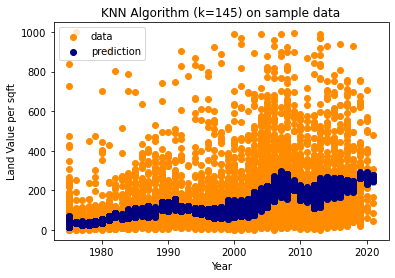

In [13]:
# Evaluate model
plt.scatter(X_test['roll_landbaseyear'], y_test, color="darkorange", label="data")
plt.scatter(X_test['roll_landbaseyear'], y_pred, color="navy", label="prediction")
plt.legend()
plt.xlabel('Year')
plt.ylabel('Land Value per sqft')
plt.title("KNN Algorithm (k=145) on sample data")
plt.show()

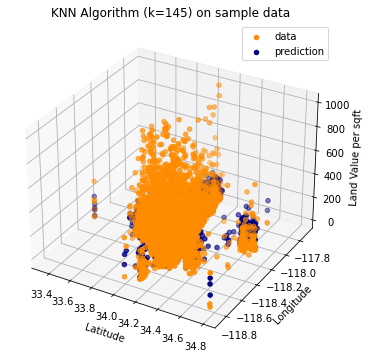

In [14]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(X_test['center_lat'], X_test['center_lon'], y_test, color="darkorange", label="data")
ax.scatter3D(X_test['center_lat'], X_test['center_lon'], y_pred, color="navy", label="prediction")
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Land Value per sqft')
plt.title("KNN Algorithm (k=145) on sample data")
plt.show()

In [15]:
error = sqrt(mean_squared_error(y_test,y_pred))
error

122.23232348269849

In [16]:
# Create a dataframe that contains all columns, but only rows where landbaseyear is 2021
df_assess = df.copy()
df_assess = df_assess[df_assess['roll_landbaseyear'] == 2021]
df_assess

,sqftmain,roll_landvalue,roll_landbaseyear,center_lat,center_lon,landvaluepersqft
410,1300.0,180000.0,2021,33.976127,-118.256092,138.461538
1972,2211.0,300000.0,2021,33.854559,-118.190454,135.685210
4496,10010.0,2000000.0,2021,34.039579,-118.315336,199.800200
7132,1800.0,460000.0,2021,33.835648,-118.328291,255.555556
9987,6396.0,2000000.0,2021,33.771413,-118.150569,312.695435
10749,1855.0,80000.0,2021,34.678218,-118.451900,43.126685
11612,152076.0,12715000.0,2021,34.223669,-118.377940,83.609511
11898,95976.0,8850000.0,2021,34.109284,-117.824483,92.210553
12887,2080.0,1000000.0,2021,33.918572,-118.401891,480.769231
15333,1561.0,1000000.0,2021,34.083735,-118.599532,640.614990


In [17]:
# Make predictions for the land value per squarefoot for the properties that were assessed in 2021 (y_assess_pred), 
# and compare them to the actual values (y_assess)
X_assess = pd.DataFrame(df_assess[['roll_landbaseyear','center_lat', 'center_lon']])
y_assess = pd.DataFrame(df_assess['landvaluepersqft'])
y_assess_pred = knn.predict(X_assess)

In [18]:
print("For properties assessed in 2021")
print("Mean predicted LV/sqft: ", y_assess_pred.mean())
print("Mean actual LV/sqft: ", y_assess['landvaluepersqft'].mean())
print("St. Dev of predicted LV/sqft: ", y_assess_pred.std())
print("St. Dev of actual LV/sqft: ", y_assess['landvaluepersqft'].std())
print("Mean error: ", sqrt(mean_squared_error(y_assess,y_assess_pred)))

For properties assessed in 2021
Mean predicted LV/sqft:  257.40052398398507
Mean actual LV/sqft:  228.62254697365842
St. Dev of predicted LV/sqft:  13.12087268703399
St. Dev of actual LV/sqft:  163.84551936980918
Mean error:  158.69059760145117


In [19]:
# Create a copy of X, but with all landbaseyear values replaced with 2021
X_current = X.copy()
X_current["roll_landbaseyear"] = 2021
X_current

,roll_landbaseyear,center_lat,center_lon
15,2021,34.095796,-118.228163
21,2021,33.947870,-118.265508
24,2021,33.996590,-118.429746
34,2021,34.078510,-118.118021
38,2021,33.996502,-118.428373
...,...,...,...
40081,2021,33.895317,-118.125651
40082,2021,34.378673,-118.547262
40083,2021,33.969522,-118.148882
40084,2021,34.140756,-118.219785


In [20]:
# Predict land value for each property if it were assessed in 2021 based on latitude and longitude
y_current = knn.predict(X_current)

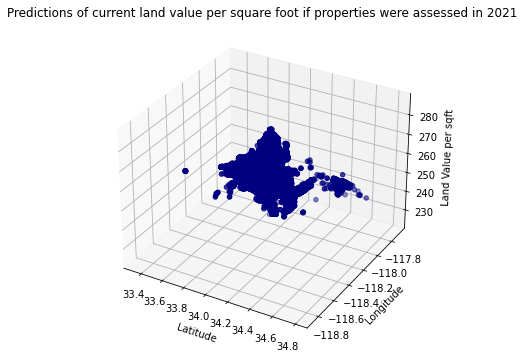

In [21]:
# Plot the predictions for land value per sqft if properties were assessed in 2021
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(X_current['center_lat'], X_current['center_lon'], y_current, color="navy")
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Land Value per sqft')
plt.title("Predictions of current land value per square foot if properties were assessed in 2021")
plt.show()